Library required

In [81]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import pdfplumber
from IPython.display import display, HTML
import time
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import (
    NoSuchElementException,
    TimeoutException,
    StaleElementReferenceException,
)

## Job Data Collection

Config

In [85]:
QUERY = "data coop"
LOCATION = "Canada"
MAX_PAGES = 10
OUTPUT_FILE = "data/jobs.csv"
BASE_URL = "https://ca.indeed.com/jobs"

Set up driver

In [86]:
def create_driver():
    chrome_options = Options()
    chrome_options.add_argument("--disable-blink-features=AutomationControlled")
    chrome_options.add_argument("--start-maximized")
    return webdriver.Chrome(options=chrome_options)

Scraper

In [87]:
def scrape_indeed_coop():
    driver = create_driver()
    wait = WebDriverWait(driver, 15)

    results = []
    seen_jobs = set()  # deduplicate overlapping pages

    try:
        for page in range(MAX_PAGES):
            start = page * 10
            print(f"[INFO] Fetching page {page + 1}")

            driver.get(
                f"{BASE_URL}?q={QUERY.replace(' ', '+')}&l={LOCATION}&start={start}"
            )

            try:
                wait.until(
                    EC.presence_of_element_located(
                        (By.CSS_SELECTOR, "div.job_seen_beacon")
                    )
                )
            except TimeoutException:
                print("[INFO] No more pages")
                break

            job_cards = driver.find_elements(By.CSS_SELECTOR, "div.job_seen_beacon")
            print(f"[INFO] Found {len(job_cards)} job cards")

            if not job_cards:
                break

            for card in job_cards:
                try:
                    # ---- TITLE ----
                    title = card.find_element(
                        By.CSS_SELECTOR, "h2.jobTitle span"
                    ).text.strip()

                    # ---- COMPANY ----
                    try:
                        company = card.find_element(
                            By.CSS_SELECTOR, "span[data-testid='company-name']"
                        ).text.strip()
                    except NoSuchElementException:
                        company = "Not specified"

                    # ---- LOCATION ----
                    try:
                        location = card.find_element(
                            By.CSS_SELECTOR, "div[data-testid='text-location']"
                        ).text.strip()
                    except NoSuchElementException:
                        location = "Not specified"

                    # ---- JOB LINK (NEW) ----
                    job_link = card.find_element(
                        By.CSS_SELECTOR, "a"
                    ).get_attribute("href")

                    job_key = f"{title}|{company}|{location}"
                    if job_key in seen_jobs:
                        continue
                    seen_jobs.add(job_key)

                    # ---- OPEN JOB DETAIL PAGE ----
                    driver.execute_script("window.open(arguments[0]);", job_link)
                    driver.switch_to.window(driver.window_handles[-1])

                    # ---- JOB DESCRIPTION ----
                    try:
                        desc_elem = wait.until(
                            EC.presence_of_element_located(
                                (By.ID, "jobDescriptionText")
                            )
                        )
                        job_description = desc_elem.text.strip()
                    except TimeoutException:
                        job_description = "Not specified"

                    driver.close()
                    driver.switch_to.window(driver.window_handles[0])

                    results.append(
                        {
                            "title": title,
                            "company": company,
                            "location": location,
                            "link": job_link,        
                            "description": job_description,
                        }
                    )

                except StaleElementReferenceException:
                    print("[WARN] Stale element, skipping job")
                except Exception as e:
                    print(f"[WARN] Skipping job due to error: {e}")

            time.sleep(2)

    finally:
        driver.quit()

    return results

Save to CSV

In [88]:
def save_to_csv(jobs):
    with open(OUTPUT_FILE, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(
            f,
            fieldnames=[
                "title",
                "company",
                "location",
                "link",        
                "description",
            ],
        )
        writer.writeheader()
        writer.writerows(jobs)

    print(f"[INFO] Saved {len(jobs)} jobs to {OUTPUT_FILE}")

Main

In [91]:
if __name__ == "__main__":
    jobs = scrape_indeed_coop()
    save_to_csv(jobs)

[INFO] Fetching page 1
[INFO] Found 16 job cards
[INFO] Fetching page 2
[INFO] No more pages
[INFO] Saved 16 jobs to data/jobs.csv


## 

Load file

In [72]:
RESUME_PDF_PATH = "data/resume.pdf"
JOBS_CSV_PATH   = "data/jobs.csv"

# Function to extract text from a PDF file
def pdf_to_text(pdf_path: str) -> str:
    text_parts = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            t = page.extract_text() or ""
            text_parts.append(t)
    return "\n".join(text_parts)

resume_text = pdf_to_text(RESUME_PDF_PATH)

resume_df = pd.DataFrame([
    {
        "resume_id": "0",        # single resume
        "resume_text": resume_text
    }
])

jobs_df   = pd.read_csv(JOBS_CSV_PATH)
# create job_id using row number
jobs_df["job_id"] = jobs_df.index.astype(str)

Data processing 

In [73]:
# change to all lower case, delete all special characters and delete extra spaces in between
def normalize_txt (txt:str)->str:
    txt=(txt or "").lower()
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

# resume
resume_df["resume_text_norm"] = resume_df["resume_text"].apply(normalize_txt)

# job posting
# only focus on skills and job descriptions, ignore location and company columns for now
jobs_df["job_text_raw"] = jobs_df["description"].fillna("").astype(str)
jobs_df["job_text_norm"] = jobs_df["job_text_raw"].apply(normalize_txt)


Embedding

In [74]:
model = SentenceTransformer("all-MiniLM-L6-v2")

resume_emb = model.encode(
    resume_df["resume_text_norm"].tolist(),
    normalize_embeddings=True
)

job_emb = model.encode(
    jobs_df["job_text_norm"].tolist(),
    normalize_embeddings=True
)

similarity_matrix = cosine_similarity(resume_emb, job_emb)

print("similarity_matrix shape:", similarity_matrix.shape)
# should be (1, number of job posting)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


similarity_matrix shape: (1, 84)


Ranking 

In [75]:
sim_df = (
    pd.DataFrame(
        similarity_matrix,
        index=resume_df["resume_id"],
        columns=jobs_df["job_id"]
    )
    .stack()
    .rename("similarity")
    .reset_index()
)

# attach job title for readability
sim_df = sim_df.merge(
    jobs_df[["job_id", "title", "company", "link"]],
    on="job_id",
    how="left"
)

# Example: get Top-K jobs for one resume
TOP_K = 10

top_matches = (
    sim_df
    .sort_values("similarity", ascending=False)
    .head(TOP_K)
    .reset_index(drop=True)
)

top_matches["job_link"] = top_matches["link"].apply(
    lambda u: f'<a href="{u}" target="_blank">View job</a>'
)

display(
    HTML(
        top_matches[["job_id", "title", "company", "similarity", "job_link"]]
        .to_html(escape=False, index=False)
    )
)

job_id,title,company,similarity,job_link
10,Développeur Power BI,CBZ Technologies,0.467810,View job
65,"Talent Acquisition Lead, Campus",Hatch,0.451619,View job
38,Integrated Pest Management Technician,Regional Municipality of Wood Buffalo,0.435156,View job
64,Structural Engineer-in-Training (EIT) - New Graduate,Hatch,0.427829,View job
82,S&I Technical Associate,Teng Inc.,0.417428,View job
43,Air Traffic Management (ATM) Tower Products - Co-op Student- Summer 2026,NAV Canada,0.412729,View job
61,"Co-op, Project Coordinator (Suncor/Syncrude Sites)",North American Construction Group Inc.,0.409128,View job
52,Sales Adminsitrator (Canada),TCL North America,0.403043,View job
23,Accounting Summer COOP,"Foresters Financial Services, Inc.",0.401569,View job
63,Co-op & Career Strategist,University of British Columbia,0.401517,View job


Visulization 

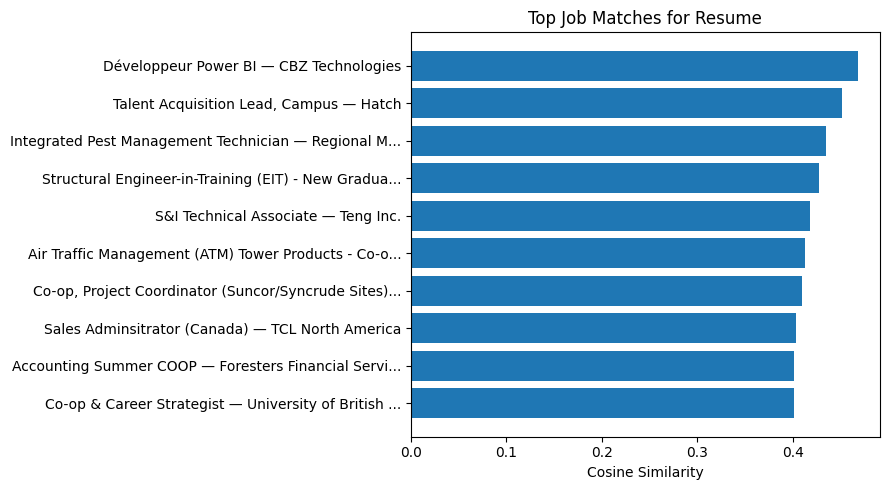

In [76]:
def plot_topk_similarity_horizontal(sim_df, k=10):
    tmp = (
        sim_df
        .sort_values("similarity", ascending=False)
        .head(k)
        .sort_values("similarity", ascending=True)
        .copy()
    )

    # combine title + company
    tmp["label"] = (
        tmp["title"].fillna("").astype(str)
        + " — "
        + tmp["company"].fillna("").astype(str)
    )

    # shorten label if too long
    tmp["label_short"] = tmp["label"].apply(
        lambda s: s[:50] + "..." if len(s) > 50 else s
    )

    plt.figure(figsize=(9, 5))
    plt.barh(tmp["label_short"], tmp["similarity"])
    plt.xlabel("Cosine Similarity")
    plt.title("Top Job Matches for Resume")
    plt.tight_layout()
    plt.show()

plot_topk_similarity_horizontal(sim_df, k=10)